<a href="https://colab.research.google.com/github/awaiskhan005/DEEP-LEARNING-AND-FORECASTING/blob/main/Time_Series_Forecasting_with_Generative_AI_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Data fetched successfully!
Epoch 1/50, Loss: 0.0483
Epoch 2/50, Loss: 0.0043
Epoch 3/50, Loss: 0.0013
Epoch 4/50, Loss: 0.0012
Epoch 5/50, Loss: 0.0009
Epoch 6/50, Loss: 0.0008
Epoch 7/50, Loss: 0.0008
Epoch 8/50, Loss: 0.0007
Epoch 9/50, Loss: 0.0008
Epoch 10/50, Loss: 0.0007
Epoch 11/50, Loss: 0.0007
Epoch 12/50, Loss: 0.0006
Epoch 13/50, Loss: 0.0006
Epoch 14/50, Loss: 0.0006
Epoch 15/50, Loss: 0.0006
Epoch 16/50, Loss: 0.0006
Epoch 17/50, Loss: 0.0005
Epoch 18/50, Loss: 0.0005
Epoch 19/50, Loss: 0.0005
Epoch 20/50, Loss: 0.0005
Epoch 21/50, Loss: 0.0005
Epoch 22/50, Loss: 0.0004
Epoch 23/50, Loss: 0.0005
Epoch 24/50, Loss: 0.0005
Epoch 25/50, Loss: 0.0005
Epoch 26/50, Loss: 0.0004
Epoch 27/50, Loss: 0.0004
Epoch 28/50, Loss: 0.0005
Epoch 29/50, Loss: 0.0004
Epoch 30/50, Loss: 0.0004
Epoch 31/50, Loss: 0.0004
Epoch 32/50, Loss: 0.0003
Epoch 33/50, Loss: 0.0003
Epoch 34/50, Loss: 0.0004
Epoch 35/50, Loss: 0.0003
Epoch 36/50, Loss: 0.0003
Epoch 37/50, Loss: 0.0004
Epoch 38/50, Loss: 0

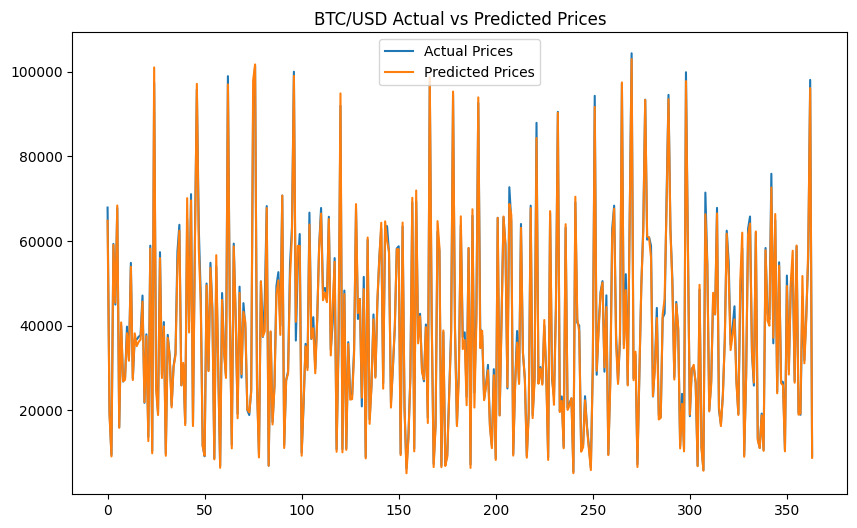

In [3]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

# Fetch BTC/USD data from yfinance
def fetch_data(ticker="BTC-USD", start="2020-01-01", end="2025-01-24"):
    data = yf.download(ticker, start=start, end=end)
    data = data["Close"]  # Use closing prices for forecasting
    return data

# Preprocess the data
def preprocess_data(data, lookback=30):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i - lookback:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.expand_dims(X, axis=2)  # Add channel dimension for PyTorch
    return X, y, scaler

# Define a simple LSTM-based forecasting model
class ChronosModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(ChronosModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last LSTM output
        return out

# Train the model
def train_model(model, X_train, y_train, epochs=50, batch_size=32, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_data = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                torch.tensor(y_train, dtype=torch.float32))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# Forecast the next day
def forecast_next_day(model, data, scaler, lookback=30):
    model.eval()
    with torch.no_grad():
        last_sequence = data[-lookback:].reshape(1, -1, 1)
        last_sequence = torch.tensor(last_sequence, dtype=torch.float32)
        prediction = model(last_sequence).item()
        return scaler.inverse_transform([[prediction]])[0, 0]

# Main function
def main():
    # Step 1: Fetch and preprocess data
    data = fetch_data()
    print("Data fetched successfully!")

    X, y, scaler = preprocess_data(data)

    # Step 2: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 3: Initialize and train the Chronos model
    model = ChronosModel()
    train_model(model, X_train, y_train, epochs=50)

    # Step 4: Forecast the next day
    next_day_forecast = forecast_next_day(model, X, scaler)
    print(f"Next day's forecasted BTC/USD price: {next_day_forecast:.2f}")

    # Step 5: Plot the actual vs predicted values
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_test, dtype=torch.float32)).numpy()
        predictions = scaler.inverse_transform(predictions)
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, label="Actual Prices")
    plt.plot(predictions, label="Predicted Prices")
    plt.legend()
    plt.title("BTC/USD Actual vs Predicted Prices")
    plt.show()

if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed


Data fetched successfully!
Epoch 1/20, Loss: 0.0358
Epoch 2/20, Loss: 0.0040
Epoch 3/20, Loss: 0.0011
Epoch 4/20, Loss: 0.0010
Epoch 5/20, Loss: 0.0010
Epoch 6/20, Loss: 0.0008
Epoch 7/20, Loss: 0.0008
Epoch 8/20, Loss: 0.0008
Epoch 9/20, Loss: 0.0007
Epoch 10/20, Loss: 0.0007
Epoch 11/20, Loss: 0.0007
Epoch 12/20, Loss: 0.0007
Epoch 13/20, Loss: 0.0007
Epoch 14/20, Loss: 0.0007
Epoch 15/20, Loss: 0.0006
Epoch 16/20, Loss: 0.0006
Epoch 17/20, Loss: 0.0006
Epoch 18/20, Loss: 0.0005
Epoch 19/20, Loss: 0.0005
Epoch 20/20, Loss: 0.0005
Next day's forecasted BTC/USD price: 96820.04


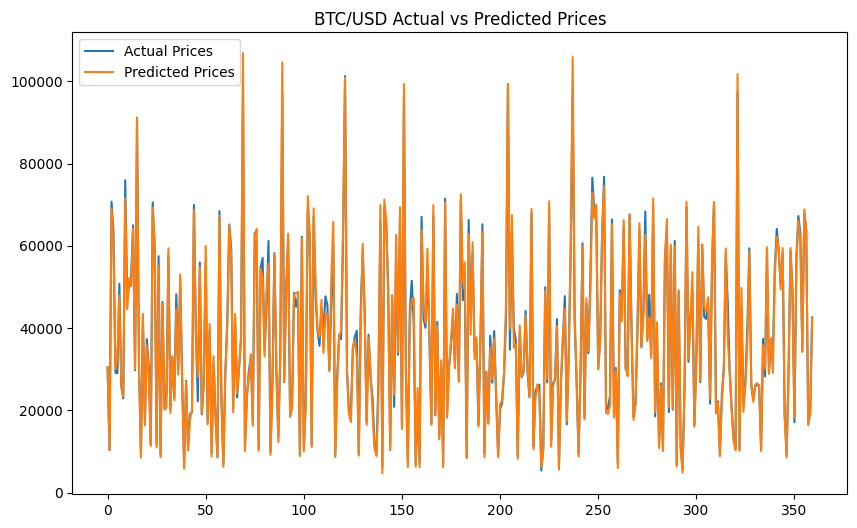

In [1]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

# Fetch BTC/USD data from yfinance
def fetch_data(ticker="BTC-USD", start="2020-01-01", end="2025-01-01"):
    data = yf.download(ticker, start=start, end=end)
    data = data["Close"]  # Use closing prices for forecasting
    return data

# Preprocess the data
def preprocess_data(data, lookback=30):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i - lookback:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.expand_dims(X, axis=2)  # Add channel dimension for PyTorch
    return X, y, scaler

# Define a simple LSTM-based forecasting model
class ChronosModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(ChronosModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last LSTM output
        return out

# Train the model
def train_model(model, X_train, y_train, epochs=50, batch_size=32, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_data = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                torch.tensor(y_train, dtype=torch.float32))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# Forecast the next day
def forecast_next_day(model, data, scaler, lookback=30):
    """
    Forecast the next day's value based on the last sequence of lookback days.
    """
    model.eval()  # Put the model in evaluation mode
    with torch.no_grad():
        # Prepare the last sequence for forecasting
        last_sequence = data[-lookback:].reshape(1, -1, 1)
        last_sequence = torch.tensor(last_sequence, dtype=torch.float32)

        # Predict the next value
        prediction = model(last_sequence).item()

        # Rescale back to original scale
        return scaler.inverse_transform([[prediction]])[0, 0]

# Main function
def main():
    # Step 1: Fetch and preprocess data
    data = fetch_data()
    print("Data fetched successfully!")

    X, y, scaler = preprocess_data(data)

    # Step 2: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 3: Initialize and train the Chronos model
    model = ChronosModel()
    train_model(model, X_train, y_train, epochs=20)

    # Step 4: Forecast the next day
    next_day_forecast = forecast_next_day(model, X, scaler)
    print(f"Next day's forecasted BTC/USD price: {next_day_forecast:.2f}")

    # Step 5: Plot the actual vs predicted values
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_test, dtype=torch.float32)).numpy()
        predictions = scaler.inverse_transform(predictions)
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, label="Actual Prices")
    plt.plot(predictions, label="Predicted Prices")
    plt.legend()
    plt.title("BTC/USD Actual vs Predicted Prices")
    plt.show()

if __name__ == "__main__":
    main()
